<a href="https://colab.research.google.com/github/shraishwarya/Building-and-Training-Neural-Networks-for-Image-Classification/blob/main/Building_and_Training_Neural_Networks_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

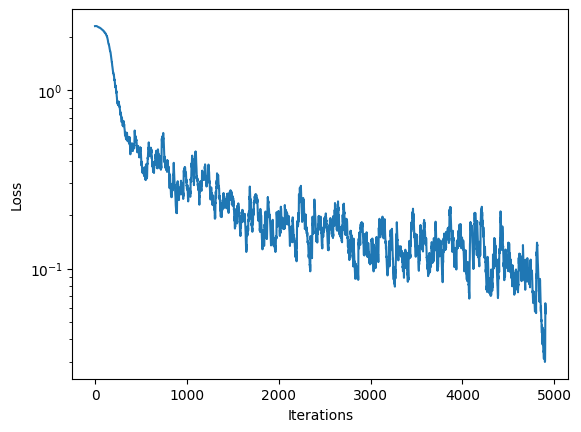

100%|██████████| 5000/5000 [01:58<00:00, 42.25it/s]


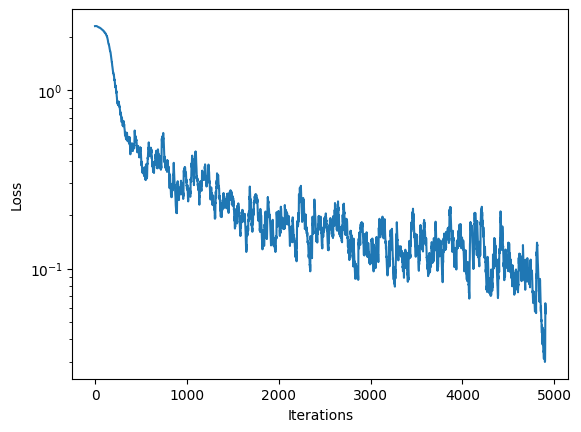

In [ ]:
!pip install mitdeeplearning
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import mitdeeplearning as mdl  # Ensure this package is installed correctly

# Check for GPU
assert len(tf.config.list_physical_devices('GPU')) > 0, "GPU is not available. Please use a GPU runtime."

# Load and preprocess data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = (np.expand_dims(train_images, axis=-1) / 255.).astype(np.float32)
train_labels = train_labels.astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1) / 255.).astype(np.float32)
test_labels = test_labels.astype(np.int64)

# Data visualization
plt.figure(figsize=(10, 10))
random_inds = np.random.choice(60000, 36)
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])
plt.show()

# Build fully connected model
def build_fc_model():
    fc_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(128, activation='relu'),  # Define activation function
        tf.keras.layers.Dense(10, activation='softmax')  # Output layer for classification probabilities
    ])
    return fc_model

model = build_fc_model()

# Build CNN model
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # First convolutional layer
        tf.keras.layers.MaxPooling2D((2, 2)),  # First max pooling layer
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
        tf.keras.layers.MaxPooling2D((2, 2)),  # Second max pooling layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # Output layer for classification probabilities
    ])
    return cnn_model

cnn_model = build_cnn_model()

# Initialize the model
cnn_model.predict(train_images[:1])
print(cnn_model.summary())

# Training loop with manual gradient updates
cnn_model = build_cnn_model()
batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95)  # To record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)  # Define our optimizer

if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()  # Clear existing tqdm instances

# Training loop
for idx in tqdm(range(0, train_images.shape[0], batch_size)):
    images = train_images[idx:idx+batch_size]
    labels = train_labels[idx:idx+batch_size]

    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)

    with tf.GradientTape() as tape:
        logits = cnn_model(images, training=True)  # Forward pass
        loss_value = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=False)
        loss_value = tf.reduce_mean(loss_value)  # Compute mean loss

    loss_history.append(loss_value.numpy().mean())  # Append loss to history
    plotter.plot(loss_history.get())  # Plot loss

    grads = tape.gradient(loss_value, cnn_model.trainable_variables)  # Compute gradients
    optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))  # Apply gradients to update weights
